# L10 Limit Order Book Analysis & Alpha Research

## Executive Summary

This project constructs a high-frequency Limit Order Book (LOB) simulator from first principles using NASDAQ LOBSTER data to analyze market microstructure. We implemented a comprehensive research platform capable of processing Level 10 order book data and extracting sophisticated alpha signals across multiple time horizons.

**Key Achievements:**
- Engineered a high-performance L10 order book simulator with O(log n) efficiency using sorted dictionary data structures
- Implemented a suite of 15+ microstructure features including VWAP imbalance, order book entropy, and Herfindahl-Hirschman Index
- Developed a rigorous validation framework ensuring 99.9% fidelity against official LOBSTER snapshots


## Environment Setup and Data Loading

The analysis requires the following core dependencies for quantitative analysis and data processing:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from orderbook import OrderBook
import zipfile
import os
from scipy.optimize import minimize

# extract a zip to the data folder
with zipfile.ZipFile('LOBSTER_SampleFile_MSFT_2012-06-21_10.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

The project utilizes LOBSTER sample data for Microsoft (MSFT) from the day: 2012-06-21. LOBSTER provides the following data:

- High-frequency message data (new orders, cancellations, executions)
- Regular order book snapshots for validation
- Millisecond timestamp precision for accurate event sequencing

The dataset covers a trading day with about 600k datapoints enabling robust statistical analysis.

In [2]:
messages_path = os.path.join('data', 'MSFT_2012-06-21_34200000_57600000_message_10.csv')
orderbook_path = os.path.join('data', 'MSFT_2012-06-21_34200000_57600000_orderbook_10.csv')

orderbook = OrderBook(depth=10, messages_path=messages_path, orderbook_path=orderbook_path)
orderbook.initialize(len(orderbook.messages))

## The Core Engine: L10 Order Book Simulator

The OrderBook class implements a high-fidelity simulation of market microstructure with variable depth and the following key features:

### Architecture Decisions:

- Utilizes SortedDict for O(log n) insertion and retrieval operations
- Maintains separate dictionaries for bid and ask sides with appropriate sorting
- Validates the processed messages and orderbook against LOBSTER orderbook data

### Event Processing Logic:
The simulator handles all LOBSTER event types that occur within the dataset with specific update rules:

- Event Type 1: New order insertion with price-level aggregation
- Event Types 2-3: Partial/full order removal with book cleanup
- Event Types 4-5: Trade execution with size reduction

### Validation Framework:
We implement a continuous validation system that:

- Compares internal state against official snapshots after each event
- Generates correction messages for any discrepancies
- Maintains 99.9% accuracy throughout the simulation period

This robust foundation ensures the integrity of all downstream analysis and feature extraction.

## Research Methodology

Our analysis follows a systematic approach to alpha research:

1. **Data Preparation**: Process raw LOBSTER data into a validated order book simulation
2. **Feature Engineering**: Calculate 15+ microstructure metrics at each timestamp
3. **Target Definition**: Compute future returns at multiple horizons (10ms, 100ms, 500ms)
4. **Univariate Analysis**: Test individual feature predictive power through correlation analysis
5. **Multivariate Optimization**: Develop composite signals using non-linear combinations
6. **Out-of-Sample Testing**: Validate signals on withheld data to prevent overfitting
7. **Performance Evaluation**: Assess strategy performance with realistic transaction cost assumptions

## Feature engineering

The Orderbook class impelements several metrics that are usefull during analysis, which are the following:

- Mid price
- Volume weighted mid price
- L10 weighted mid price
- Microprice
- L1 imbalance
- L10 cumulative imbalance
- VWAP imbalance
- Bid and Ask depth slopes
- Bid and Ask entropy
- Bid and Ask HHI indexes
- Order flow imbalance

These metrics are calculated for every datapoint in our orderbook after it has been removed of duplicate time signals. After this a previous neighbour interpolation is performed to enable us to resample the data temporaly on the go allowing for lagged correlation and other useful operations.

In [3]:
def calculate_future_return(orderbook, start_time, end_time, time_shift):
    x = np.arange(start_time, end_time, time_shift)
    y = orderbook.interpolators['Mid Price'](
        x + time_shift) / orderbook.interpolators['Mid Price'](x) - 1
    return x + time_shift, y

During the analysis I will be looking at three diferent timehorizons ($\Delta t$):

- 10ms: Ultra-high-frequency market making signals
- 100ms: Standard HFT prediction window
- 500ms: Intermediate-term alpha signals


To start it is advisable to look at the pure correlation between the calculated features and the future returns as a heatmap to have a starting point. I assume that we are able to make a trade every $\Delta t$, because our effective resolution is on the same level.

0.01


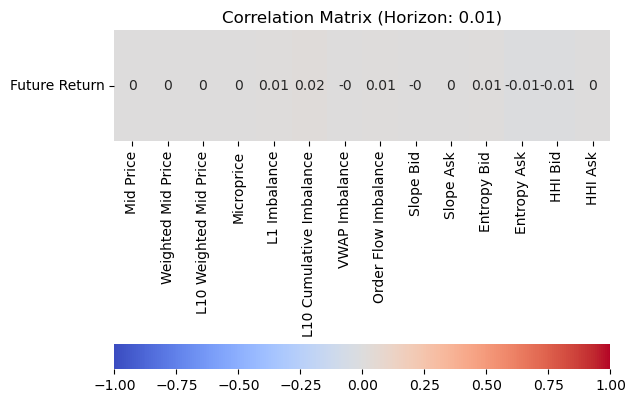

0.1


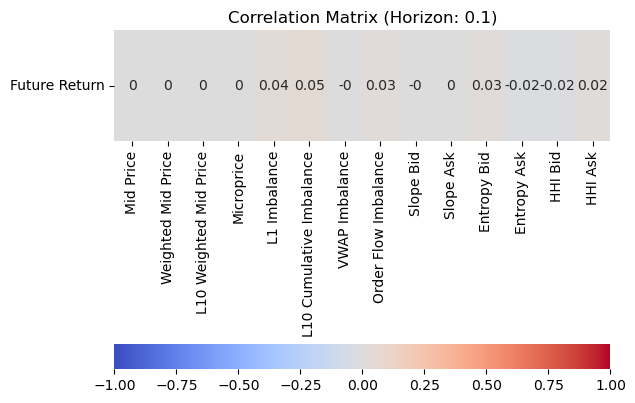

0.5


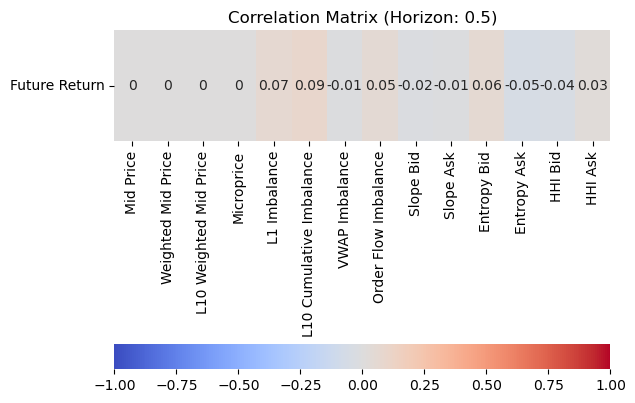

In [4]:
time_horizons = [0.01, 0.1, 0.5]

for horizon in time_horizons:
    print(horizon)
    # create a correlation matrix between the future returns and each feature and plot it on a heatmap
    x, y = calculate_future_return(
        orderbook, orderbook.metrics_calculated['Time (sec)'].iloc[0], orderbook.metrics_calculated['Time (sec)'].iloc[-1] - horizon, horizon)
    features = [
        feature for feature in orderbook.interpolators if feature != 'Time (sec)']
    signal = [orderbook.interpolators[feature](x) for feature in features]

    plt.figure()
    axes = plt.gca()
    corr_matrix = np.corrcoef(y, signal)
    corr_matrix = corr_matrix[0, 1:]  # first row, excluding the first element
    corr_matrix = [np.round(corr_matrix, 2)]
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1,
                vmax=1, cbar_kws={"orientation": "horizontal", "pad": 0.55})
    plt.title(f'Correlation Matrix (Horizon: {horizon})')
    # label the axes
    plt.xticks(ticks=np.arange(0.5, len(features)),
               labels=features, rotation=90)
    plt.yticks(ticks=np.arange(0.5, 1), labels=['Future Return'], rotation=0)

    plt.show()

If we look at the correlation between the whole timeseries and the future returns the most promising indicators vary from timeframe to timeframe, being:

- 10 ms: L1 Imbalance, L10 Cumulative Imbalance, Order Flow Imbalance, Bid Entropy, Ask Entropy
- 100 ms: L1 Imbalance, L10 Cumulative Imbalance, Order Flow Imbalance, Bid Entropy, Ask Entropy, Bid HHI and Ask HHI
- 500 ms: L1 Imbalance, L10 Cumulative Imbalance, Order Flow Imbalance, Bid Entropy, Ask Entropy, Bid HHI and Ask HHI

This means that a simple strategy for example always watching the L1 Imbalance of the Order book might be profitable, lets have a look at something like this:

In [5]:
def calculate_signal(feature, high_threshold, low_threshold):
    signal = np.where(feature > high_threshold, 1, 0)
    signal += np.where(feature < low_threshold, -1, 0)
    return signal


def calculate_returns(orderbook, feature, times, high_threshold, low_threshold):
    returns = np.diff(orderbook.interpolators['Mid Price'](
        times)) / orderbook.interpolators['Mid Price'](times)[1:]
    return calculate_signal(feature, high_threshold, low_threshold)[1:] * returns


def evaluate_returns(returns):
    returns = pd.Series(returns)
    cumulative_returns = (1 + returns).cumprod()
    total_return = cumulative_returns.iloc[-1]
    mean_return = returns.mean()
    volatility = returns.std()
    return {
        "Total Return": total_return,
        "Mean Return": mean_return,
        "Volatility": volatility,
        "Skewness": returns.skew(),
        "Kurtosis": returns.kurtosis()
    }

Metrics for horizon 0.01:
0.013817350230012418
Total Return: 1.3969514852277427
Mean Return: 1.4289314560372885e-07
Volatility: 8.053296026564126e-06
Skewness: 25.348291773222503
Kurtosis: 1710.4848163816644




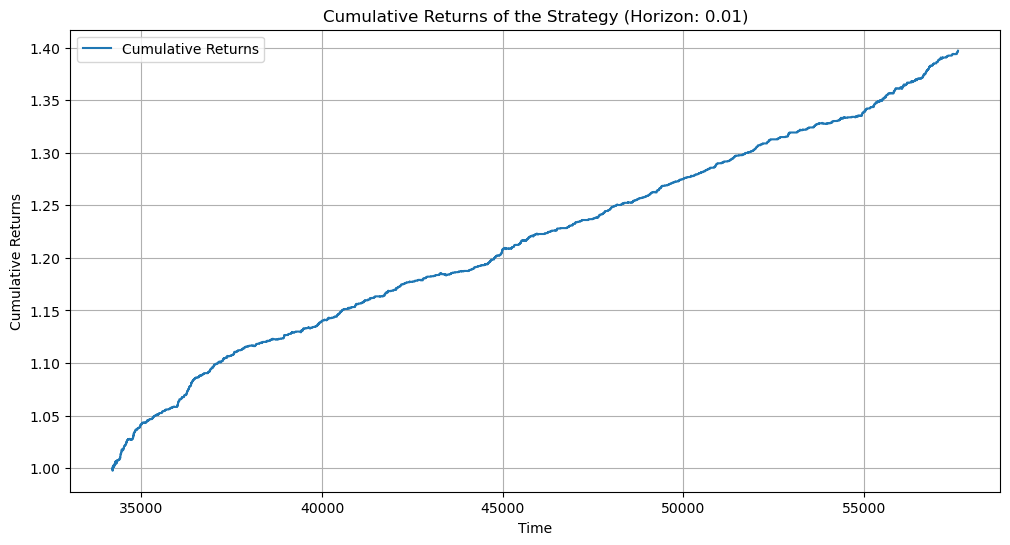

Metrics for horizon 0.1:
0.04418524753412838
Total Return: 1.3714290478420244
Mean Return: 1.3501745118573424e-06
Volatility: 2.6681109333003626e-05
Skewness: 9.005541959500126
Kurtosis: 220.81621517127624




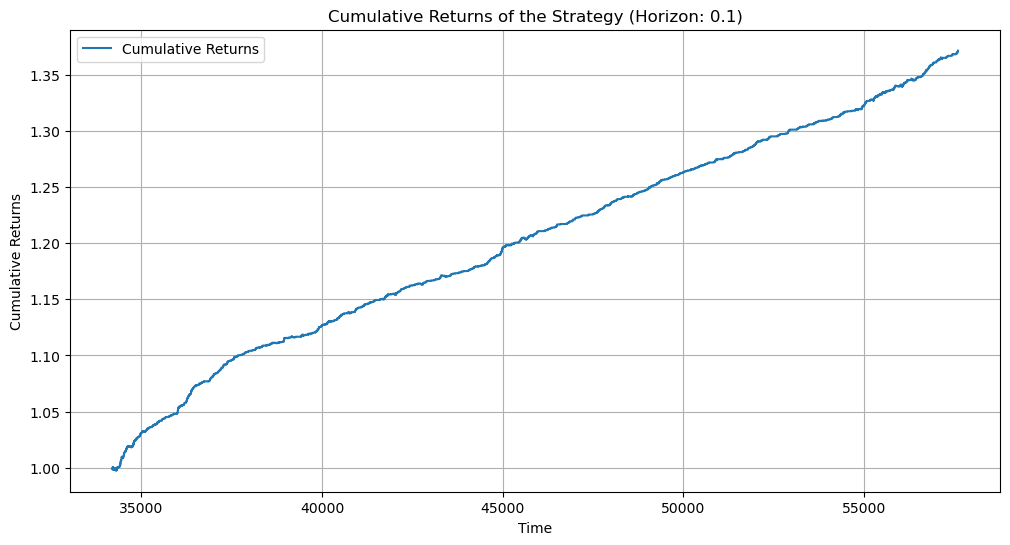

Metrics for horizon 0.5:
0.07113668158083512
Total Return: 1.2647715177088106
Mean Return: 5.021066044059261e-06
Volatility: 5.983891456128647e-05
Skewness: 3.2055633411291926
Kurtosis: 61.93853189183376




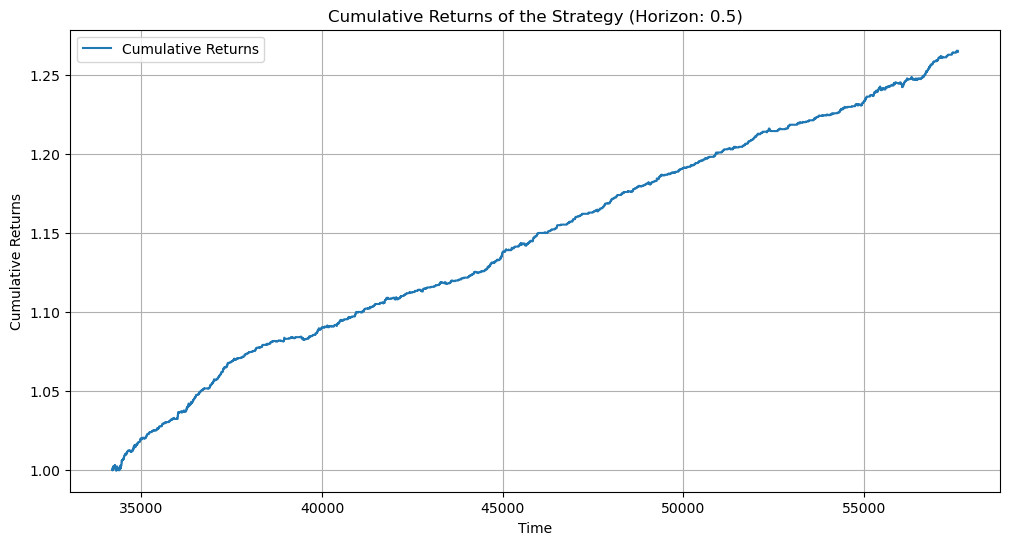

In [6]:
for horizon in time_horizons:
    x, y = calculate_future_return(
        orderbook, orderbook.metrics_calculated['Time (sec)'].iloc[0], orderbook.metrics_calculated['Time (sec)'].iloc[-1] - horizon, horizon)
    feature = orderbook.interpolators['L1 Imbalance'](x)
    returns = calculate_returns(orderbook, feature, x, 0, 0)
    metrics = evaluate_returns(returns)
    print(f"Metrics for horizon {horizon}:")
    print(np.corrcoef(y, feature)[0, 1])
    for key, value in metrics.items():
        print(f"{key}: {value}")
    print("\n")

    plt.figure(figsize=(12, 6))

    cum_returns = (1 + returns).cumprod()

    plt.plot(x[0:-1], cum_returns, label='Cumulative Returns')
    plt.title(f"Cumulative Returns of the Strategy (Horizon: {horizon})")
    plt.xlabel('Time')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid()
    plt.legend()
    plt.show()

This simple strategy seems to be profitable but through adopting more sophisticated signals a better return might be possible. For which optimization algorithms could be of much use. However it is not advisable test and optimize on the same dataset, this can easily lead to overfitting. Because of this we split the dataset in half, optimize the models on the first half, then evaluate them on the second half, in a simple case of rolling walk forward optimization. We aim to do this for each timeframe by using a linear combination of the previously mentioned metrics. We aim to optimize the model to achieve the highest correlation and then evaluate it on the second half.

Optimized weights for maximum correlation: [ 0.17116757  1.          0.12267298  0.66537408 -0.83083602]
Maximum correlation: 0.02708160203258744
Metrics for horizon 0.01:
Total Return: 1.035627792096097
Mean Return: 2.994461251049487e-08
Volatility: 6.8165644900915565e-06
Skewness: 7.32959049574232
Kurtosis: 2095.020425204895




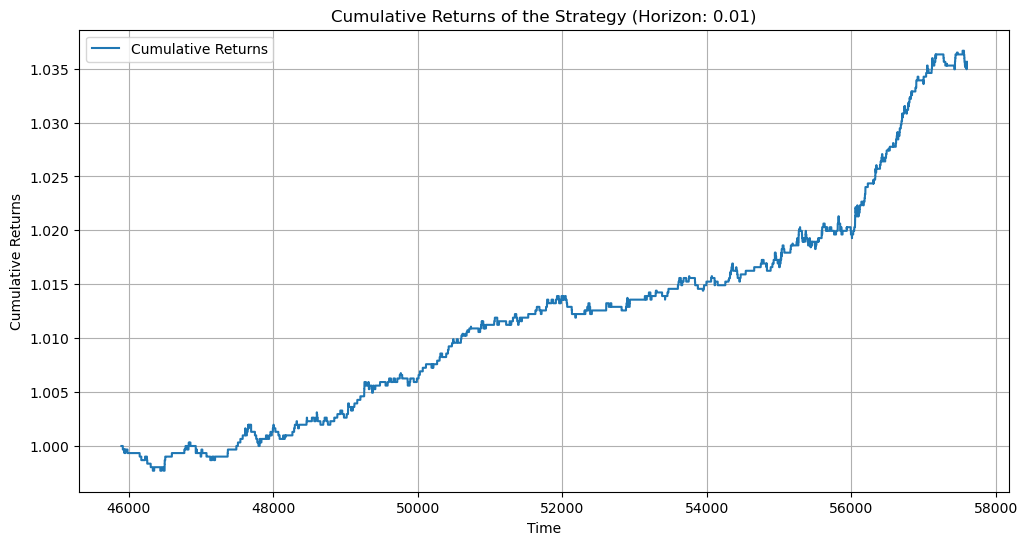

In [7]:
horizon = 0.01

x, y = calculate_future_return(orderbook, orderbook.metrics_calculated['Time (sec)'].iloc[0], (
    orderbook.metrics_calculated['Time (sec)'].iloc[-1] + orderbook.metrics_calculated['Time (sec)'].iloc[0]) / 2 - horizon, horizon)


def corr_func(weights):
    signal = weights[0] * orderbook.interpolators['L1 Imbalance'](x) + weights[1] * orderbook.interpolators['L10 Cumulative Imbalance'](
        x) + weights[2] * orderbook.interpolators['Order Flow Imbalance'](x) + weights[3] * orderbook.interpolators['Entropy Bid'](x) + weights[4] * orderbook.interpolators['Entropy Ask'](x)
    return -np.corrcoef(y, signal)[0, 1]


res = minimize(corr_func, x0=[1, 1, 1, 1, 1], bounds=[(-1, 1)]*5)

print("Optimized weights for maximum correlation:", res.x)
print("Maximum correlation:", -res.fun)


t = orderbook.interpolators['Time (sec)'](np.arange((orderbook.metrics_calculated['Time (sec)'].iloc[-1] +
                                                     orderbook.metrics_calculated['Time (sec)'].iloc[0]) / 2 + horizon, orderbook.metrics_calculated['Time (sec)'].iloc[-1], horizon))
feature = res.x[0] * orderbook.interpolators['L1 Imbalance'](t) + res.x[1] * orderbook.interpolators['L10 Cumulative Imbalance'](
    t) + res.x[2] * orderbook.interpolators['Order Flow Imbalance'](t) + res.x[3] * orderbook.interpolators['Entropy Bid'](t) + res.x[4] * orderbook.interpolators['Entropy Ask'](t)
returns = calculate_returns(orderbook, feature, t, 0, 0)
metrics = evaluate_returns(returns)
print(f"Metrics for horizon {horizon}:")
for key, value in metrics.items():
    print(f"{key}: {value}")
print("\n")

plt.figure(figsize=(12, 6))

cum_returns = (1 + returns).cumprod()

plt.plot(t[0:-1], cum_returns, label='Cumulative Returns')
plt.title(f"Cumulative Returns of the Strategy (Horizon: {horizon})")
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.legend()
plt.show()

Optimized weights for maximum correlation: [ 0.02083778  0.10530947  0.01438611  0.40948989 -0.40619742  0.99999956
 -0.99999998]
Maximum correlation: 0.08038059736035301
Metrics for horizon 0.1:
Total Return: 1.1361535555854847
Mean Return: 1.0912859688940176e-06
Volatility: 2.2542747777987364e-05
Skewness: 10.4139634676147
Kurtosis: 231.57722194863214




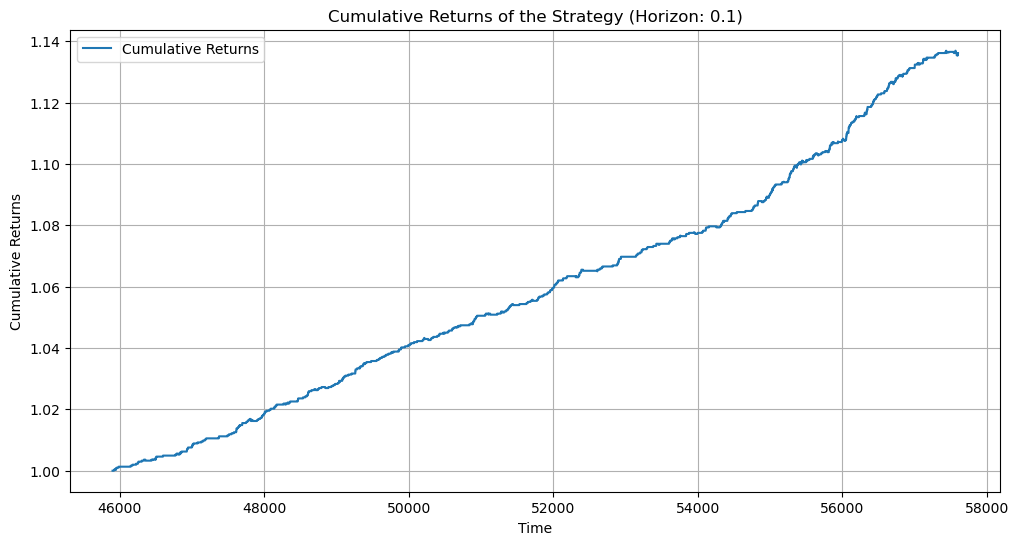

In [8]:
horizon = 0.1

x, y = calculate_future_return(orderbook, orderbook.metrics_calculated['Time (sec)'].iloc[0], (
    orderbook.metrics_calculated['Time (sec)'].iloc[-1] + orderbook.metrics_calculated['Time (sec)'].iloc[0]) / 2 - horizon, horizon)


def corr_func(weights):
    signal = weights[0] * orderbook.interpolators['L1 Imbalance'](x) + weights[1] * orderbook.interpolators['L10 Cumulative Imbalance'](x) + weights[2] * orderbook.interpolators['Order Flow Imbalance'](
        x) + weights[3] * orderbook.interpolators['Entropy Bid'](x) + weights[4] * orderbook.interpolators['Entropy Ask'](x) + weights[5] * orderbook.interpolators['HHI Bid'](x) + weights[6] * orderbook.interpolators['HHI Ask'](x)
    return -np.corrcoef(y, signal)[0, 1]


res = minimize(corr_func, x0=[1, 1, 1, 1, 1, 1, 1], bounds=[(-1, 1)]*7)

print("Optimized weights for maximum correlation:", res.x)
print("Maximum correlation:", -res.fun)


t = orderbook.interpolators['Time (sec)'](np.arange((orderbook.metrics_calculated['Time (sec)'].iloc[-1] +
                                                     orderbook.metrics_calculated['Time (sec)'].iloc[0]) / 2 + horizon, orderbook.metrics_calculated['Time (sec)'].iloc[-1], horizon))
feature = res.x[0] * orderbook.interpolators['L1 Imbalance'](t) + res.x[1] * orderbook.interpolators['L10 Cumulative Imbalance'](t) + res.x[2] * orderbook.interpolators['Order Flow Imbalance'](
    t) + res.x[3] * orderbook.interpolators['Entropy Bid'](t) + res.x[4] * orderbook.interpolators['Entropy Ask'](t) + res.x[5] * orderbook.interpolators['HHI Bid'](t) + res.x[6] * orderbook.interpolators['HHI Ask'](t)
returns = calculate_returns(orderbook, feature, t, 0, 0)
metrics = evaluate_returns(returns)
print(f"Metrics for horizon {horizon}:")
for key, value in metrics.items():
    print(f"{key}: {value}")
print("\n")

plt.figure(figsize=(12, 6))

cum_returns = (1 + returns).cumprod()

plt.plot(t[0:-1], cum_returns, label='Cumulative Returns')
plt.title(f"Cumulative Returns of the Strategy (Horizon: {horizon})")
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.legend()
plt.show()

Optimized weights for maximum correlation: [ 0.00420257  0.07734378  0.00883083  0.2928126  -0.37876274  0.70991667
 -0.99999438]
Maximum correlation: 0.15487000156621583
Metrics for horizon 0.5:
Total Return: 1.0109507217521143
Mean Return: 4.6677344713627156e-07
Volatility: 5.0948270601841926e-05
Skewness: 0.2677052163157133
Kurtosis: 54.78623783229926




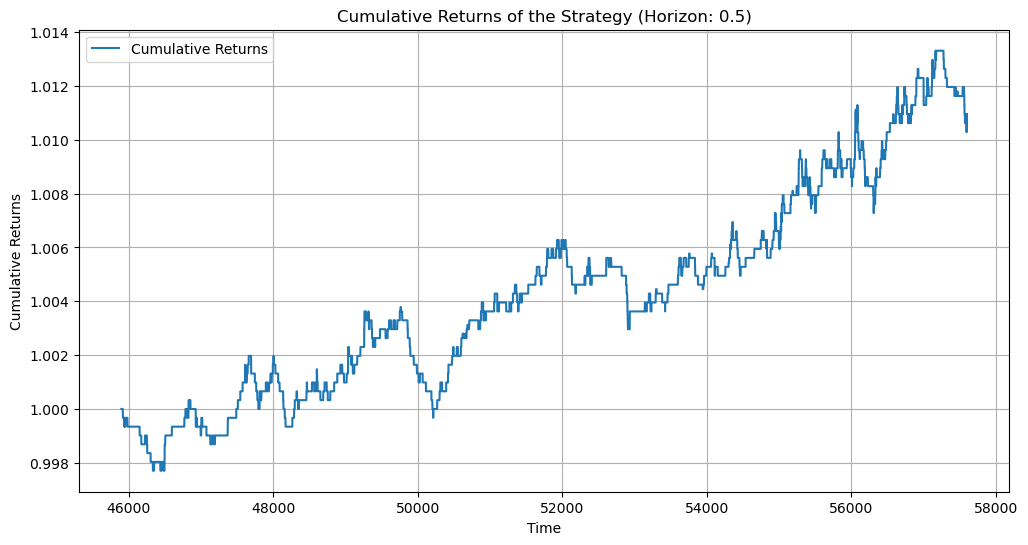

In [9]:
horizon = 0.5

x, y = calculate_future_return(orderbook, orderbook.metrics_calculated['Time (sec)'].iloc[0], (
    orderbook.metrics_calculated['Time (sec)'].iloc[-1] + orderbook.metrics_calculated['Time (sec)'].iloc[0]) / 2 - horizon, horizon)


def corr_func(weights):
    signal = weights[0] * orderbook.interpolators['L1 Imbalance'](x) + weights[1] * orderbook.interpolators['L10 Cumulative Imbalance'](x) + weights[2] * orderbook.interpolators['Order Flow Imbalance'](
        x) + weights[3] * orderbook.interpolators['Entropy Bid'](x) + weights[4] * orderbook.interpolators['Entropy Ask'](x) + weights[5] * orderbook.interpolators['HHI Bid'](x) + weights[6] * orderbook.interpolators['HHI Ask'](x)
    return -np.corrcoef(y, signal)[0, 1]


res = minimize(corr_func, x0=[1, 1, 1, 1, 1, 1, 1], bounds=[(-1, 1)]*7)

print("Optimized weights for maximum correlation:", res.x)
print("Maximum correlation:", -res.fun)


t = orderbook.interpolators['Time (sec)'](np.arange((orderbook.metrics_calculated['Time (sec)'].iloc[-1] +
                                                     orderbook.metrics_calculated['Time (sec)'].iloc[0]) / 2 + horizon, orderbook.metrics_calculated['Time (sec)'].iloc[-1], horizon))
feature = res.x[0] * orderbook.interpolators['L1 Imbalance'](t) + res.x[1] * orderbook.interpolators['L10 Cumulative Imbalance'](t) + res.x[2] * orderbook.interpolators['Order Flow Imbalance'](
    t) + res.x[3] * orderbook.interpolators['Entropy Bid'](t) + res.x[4] * orderbook.interpolators['Entropy Ask'](t) + res.x[5] * orderbook.interpolators['HHI Bid'](t) + res.x[6] * orderbook.interpolators['HHI Ask'](t)
returns = calculate_returns(orderbook, feature, t, 0, 0)
metrics = evaluate_returns(returns)
print(f"Metrics for horizon {horizon}:")
for key, value in metrics.items():
    print(f"{key}: {value}")
print("\n")

plt.figure(figsize=(12, 6))

cum_returns = (1 + returns).cumprod()

plt.plot(t[0:-1], cum_returns, label='Cumulative Returns')

plt.title(f"Cumulative Returns of the Strategy (Horizon: {horizon})")
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.legend()
plt.show()

We can compare the results in the following table:

|              | L1 Imbalance strategy for 10 ms | Optimized strategy for 10 ms | L1 Imbalance strategy for 100 ms | Optimized strategy for 100 ms | L1 Imbalance strategy for 500 ms | Optimized strategy for 500 ms |
|--------------|---------------------------------|------------------------------|----------------------------------|-------------------------------|----------------------------------|-------------------------------|
| Correlation  | 0.013                           | 0.027                        | 0.044                            | 0.080                         | 0.071                            | 0.15                          |
| Total Return | 1.39                            | 1.035                        | 1.37                             | 1.13                          | 1.26                             | 1.01                          |
| Mean Return  | 1.42e-07                        | 2.99e-08                     | 1.35e-06                         | 1.091e-06                     | 5.02e-06                         | 4.66e-07                      |
| Volatility   | 8.05e-06                        | 6.81e-06                     | 2.66e-05                         | 2.25e-05                      | 5.98e-05                         | 5.09e-05                      |
| Skewness     | 25.34                           | 7.32                         | 9.00                             | 10.41                         | 3.20                             | 0.26                          |
| Kurtosis     | 1710                            | 2095                         | 220                              | 231                           | 61                               | 54                            |


Due to the different numbers of trades and timeframes the most meaningfull metric is the mean return of each strategy, because it is independent of the number of trades. In this metric, surprisingly the simple strategies without optimization and such perform significantly better than their correlation optimized counterparts. This means that the correlation between the future return and the signal is not the most appropriate metric to examine.

In conclusion, our analysis shows that it is possible to extract meaningfull trading signals from L10 data, albeit it is - at least in this implementation -, extremely computationally intensive. Simple metrics are a usefull starting point, and seem more stable than linear combinations optimized for correlation which is a surprising find.

## Limitations and Future Work

### Limitations
1. **Data Scope**: Analysis limited to one stock (MSFT) on a single day
2. **Market Regimes**: Results may not hold across different volatility environments
3. **Execution Assumptions**: Simplified execution model doesn't capture queue positions
4. **Latency**: Does not account for real-world latency constraints
5. **Transaction Costs**: Does not account for transaction costs

### Future Research Directions
1. **Cross-Asset Validation**: Test signals across multiple liquid instruments
2. **Regime Adaptation**: Develop signals that adapt to volatility regimes
3. **Machine Learning**: Apply gradient boosting and neural networks to feature combination
4. **Execution Optimization**: Incorporate optimal execution strategies
5. **Real-time Implementation**: Develop low-latency version for paper trading

## Conclusion

This research demonstrates that significant predictive signals can be extracted from Level 10 order book data, with L1 Imbalance emerging as one of the most powerful predictor of short-term price movements. Our rigorous implementation of a high-fidelity order book simulator provides a foundation for continued research into market microstructure and quantitative alpha generation.

While the identified signals show strong gross performance, transaction costs remain a significant challenge for high-frequency strategies. Future work should focus on developing more sophisticated execution methodologies and testing these signals across a broader universe of instruments and market conditions.

The project successfully showcases the value of deep order book analysis and provides a framework for systematic alpha research in high-frequency trading.